In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


✅ TensorFlow hoạt động bình thường!


Found 186 files belonging to 4 classes.
Found 50 files belonging to 4 classes.
Danh sách nhãn: ['wc_clean', 'wc_moderately_dirty', 'wc_slightly_dirty', 'wc_very_dirty']
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.4512 - loss: 1.4964 - val_accuracy: 0.6000 - val_loss: 1.0290
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.7874 - loss: 0.6821 - val_accuracy: 0.5600 - val_loss: 0.9778
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.8577 - loss: 0.4474 - val_accuracy: 0.5400 - val_loss: 1.1862
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8296 - loss: 0.4353 - val_accuracy: 0.5600 - val_loss: 1.1752
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.8609 - loss: 0.3593 - val_accuracy: 0.5600 - val_loss: 0.9358
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9278 - loss: 0.2775 - val_accuracy: 0.6000 - val_loss: 0.7417
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8961 - loss: 0.2467 - val

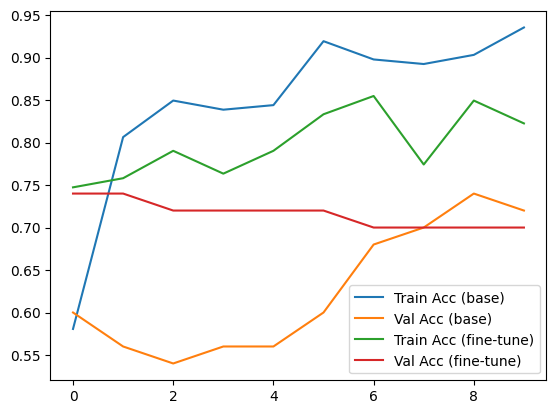

Saved artifact at '/tmp/tmpf8uixhsm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_3996')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140636024029840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140635725509264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140635725507920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140636024031376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140636024034832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140635725505424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140635725507152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140635725503504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140635725507536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140635725499280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140635725

In [ ]:
#training
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import os

# Định nghĩa đường dẫn
data_dir = "/content/drive/MyDrive/dataset/BRFloor"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Kích thước ảnh & batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load dataset với chuẩn hóa
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)
class_names = train_ds.class_names
print("Danh sách nhãn:", class_names)
# Chuẩn hóa dữ liệu về khoảng [0, 1]
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(preprocess)
test_ds = test_ds.map(preprocess)


# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

# Load mô hình MobileNetV2 pre-trained
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet")

# Đóng băng trọng số của base_model trước
base_model.trainable = False

# Xây dựng mô hình
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

# Compile mô hình
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Huấn luyện ban đầu
EPOCHS = 10
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
])

# Unfreeze một số layers để fine-tune
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Giảm learning rate khi fine-tune
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Huấn luyện lần 2
EPOCHS_FINE_TUNE = 10
history_fine = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS_FINE_TUNE)

# Vẽ biểu đồ accuracy
plt.plot(history.history['accuracy'], label='Train Acc (base)')
plt.plot(history.history['val_accuracy'], label='Val Acc (base)')
plt.plot(history_fine.history['accuracy'], label='Train Acc (fine-tune)')
plt.plot(history_fine.history['val_accuracy'], label='Val Acc (fine-tune)')
plt.legend()
plt.show()

# Lưu model
model.save("/content/drive/MyDrive/Classification/wcpj/model_wcpj_pro.h5")

# Convert mô hình sang TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Lưu lại file .tflite
with open("/content/drive/MyDrive/Classification/wcpj/model_wcpj_pro.tflite", "wb") as f:
    f.write(tflite_model)

print("Chuyển đổi sang TFLite thành công!")


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
import os

# Định nghĩa đường dẫn model và tập test
MODEL_PATH = "/content/drive/MyDrive/Classification/wcpj/model_wcpj_pro.h5"
TEST_DIR = "/content/drive/MyDrive/dataset/BRFloor/test/wc_slightly_dirty"

# Load model đã train
model = tf.keras.models.load_model(MODEL_PATH)

# Load tập test
IMG_SIZE = (224, 224)

# Hàm dự đoán một ảnh
def predict_image(image_path, model):
    img = load_img(image_path, target_size=IMG_SIZE)  # Load ảnh
    img_array = img_to_array(img) / 255.0  # Chuyển thành mảng và chuẩn hóa
    img_array = np.expand_dims(img_array, axis=0)  # Thêm batch dimension

    prediction = model.predict(img_array)  # Dự đoán
    predicted_class = np.argmax(prediction)  # Lấy lớp có xác suất cao nhất
    confidence = np.max(prediction)  # Độ tin cậy

    return predicted_class, confidence

# Test model với một số ảnh mẫu
test_images = os.listdir(TEST_DIR)[:5]  # Lấy 5 ảnh đầu tiên trong tập test

for img_name in test_images:
    img_path = os.path.join(TEST_DIR, img_name)
    predicted_class, confidence = predict_image(img_path, model)

    # Hiển thị ảnh và kết quả dự đoán
    img = load_img(img_path, target_size=IMG_SIZE)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_class}, Confidence: {confidence:.2f}')
    plt.show()



KeyboardInterrupt: 

In [ ]:
!pip install pyngrok
!ngrok authtoken 2tErzsy4uL1ioM1buBZrAhI4MPc_2KZz36FbKQ5R5StPC8UkD
!pip install flask flask-ngrok numpy pillow tensorflow
from pyngrok import ngrok

# Khởi động Flask trên cổng 5000
public_url = ngrok.connect(5000).public_url
print("Public URL:", public_url)


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Public URL: https://d7ae-35-239-208-108.ngrok-free.app


Để thực thi mã trong ô trên, hãy nhấp để chọn mã đó rồi nhấn nút phát ở bên trái mã hoặc sử dụng tổ hợp phím tắt "Command/Ctrl+Enter". Để chỉnh sửa mã này, bạn chỉ cần nhấp vào ô đó và bắt đầu chỉnh sửa.

Các biến mà bạn xác định trong một ô có thể dùng trong các ô khác sau này:

In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

Sổ tay trên Colab cho phép bạn kết hợp <strong>mã có thể thực thi</strong> và <strong>văn bản đa dạng thức</strong> trong một tài liệu duy nhất, cùng với <strong>hình ảnh</strong>, <strong>HTML</strong>, <strong>LaTeX</strong> và nhiều nội dung khác. Khi bạn tạo sổ tay của riêng mình trên Colab, các sổ tay đó sẽ được lưu trữ trong tài khoản Google Drive của bạn. Bạn có thể dễ dàng chia sẻ sổ tay của mình trên Colab với đồng nghiệp hoặc bạn bè, cho phép họ nhận xét hoặc thậm chí là chỉnh sửa các sổ tay đó. Để tìm hiểu thêm, hãy xem phần <a href="/notebooks/basic_features_overview.ipynb">Tổng quan về Colab</a>. Để tạo một sổ tay mới trên Colab, bạn có thể sử dụng trình đơn Tệp ở trên hoặc sử dụng đường liên kết sau: <a href="http://colab.research.google.com#create=true">tạo một sổ tay mới trên Colab</a>.

Sổ tay trên Colab là các sổ tay Jupyter được Colab lưu trữ. Để tìm hiểu thêm về dự án Jupyter, hãy xem <a href="https://www.jupyter.org">jupyter.org</a>.

<div class="markdown-google-sans">

## Khoa học dữ liệu
</div>

Với Colab, bạn có thể khai thác toàn bộ sức mạnh của các thư viện Python phổ biến để phân tích và trực quan hóa dữ liệu. Ô chứa mã ở bên dưới sử dụng <strong>numpy</strong> để tạo một số dữ liệu ngẫu nhiên và sử dụng <strong>matplotlib</strong> để trực quan hóa dữ liệu đó. Để chỉnh sửa mã này, bạn chỉ cần nhấp vào ô đó và bắt đầu chỉnh sửa.

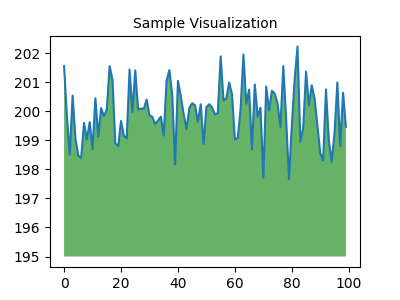

In [ ]:
import numpy as np
import IPython.display as display
from matplotlib import pyplot as plt
import io
import base64

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

fig = plt.figure(figsize=(4, 3), facecolor='w')
plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)
plt.title("Sample Visualization", fontsize=10)

data = io.BytesIO()
plt.savefig(data)
image = F"data:image/png;base64,{base64.b64encode(data.getvalue()).decode()}"
alt = "Sample Visualization"
display.display(display.Markdown(F"""![{alt}]({image})"""))
plt.close(fig)

Bạn có thể nhập dữ liệu của riêng mình vào các sổ tay trên Colab từ tài khoản Google Drive, bao gồm từ bảng tính, cũng như từ GitHub và nhiều nguồn khác. Để tìm hiểu thêm về cách nhập dữ liệu và cách áp dụng Colab cho ngành khoa học dữ liệu, hãy xem các đường liên kết trong phần <a href="#working-with-data">Làm việc với dữ liệu</a>.

<div class="markdown-google-sans">

## Máy học
</div>

Với Colab, chỉ cần sử dụng <a href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb">một vài dòng mã</a> là bạn có thể nhập tập dữ liệu hình ảnh, huấn luyện một trình phân loại hình ảnh dựa trên tập dữ liệu đó và đánh giá mô hình này. Sổ tay trên Colab thực thi mã trên các máy chủ đám mây của Google. Nhờ đó, bạn có thể tận dụng sức mạnh của phần cứng Google, bao gồm cả <a href="#using-accelerated-hardware">GPU và TPU</a>, cho dù máy tính của bạn sử dụng sức mạnh phần cứng nào. Bạn chỉ cần một trình duyệt.

Colab được sử dụng rộng rãi trong cộng đồng máy học với các ứng dụng như:
- Bắt đầu sử dụng TensorFlow
- Phát triển và huấn luyện mạng nơron
- Thử nghiệm có sử dụng TPU
- Phổ biến nghiên cứu về AI &#40;trí tuệ nhân tạo&#41;
- Tạo hướng dẫn

Để xem các sổ tay mẫu trên Colab minh họa các ứng dụng dùng mô hình máy học, hãy xem <a href="#machine-learning-examples">các ví dụ về máy học</a> ở bên dưới.

<div class="markdown-google-sans">

## Tài nguyên khác

### Làm việc với Sổ tay trong Colab

</div>

- [Tổng quan về Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Hướng dẫn sử dụng Markdown](/notebooks/markdown_guide.ipynb)
- [Nhập thư viện và cài đặt phần phụ thuộc](/notebooks/snippets/importing_libraries.ipynb)
- [Lưu và tải sổ tay trong GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Biểu mẫu tương tác](/notebooks/forms.ipynb)
- [Tiện ích tương tác](/notebooks/widgets.ipynb)

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### Làm việc với dữ liệu
</div>

- [Tải dữ liệu: Drive, Trang tính và Google Cloud Storage](/notebooks/io.ipynb)
- [Biểu đồ: trực quan hóa dữ liệu](/notebooks/charts.ipynb)
- [Bắt đầu sử dụng BigQuery](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### Khóa học máy học ứng dụng

<div>

Khóa học trực tuyến của Google về Máy học có cung cấp một số sổ tay. Hãy xem <a href="https://developers.google.com/machine-learning/crash-course/">trang web của toàn bộ khóa học</a> để biết thêm thông tin.
- [Giới thiệu về Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Hồi quy tuyến tính bằng tf.keras sử dụng dữ liệu tổng hợp](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### Sử dụng phần cứng tăng tốc
</div>

- [TensorFlow có GPU](/notebooks/gpu.ipynb)
- [TensorFlow có TPU](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### Ví dụ điển hình

</div>

- <a href="https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/VoiceSwapSample.ipynb">Ứng dụng hoán đổi giọng nói NeMo</a>: Dùng Bộ công cụ AI &#40;trí tuệ nhân tạo&#41; NeMo có khả năng trò chuyện của Nvidia để hoán đổi giọng nói trong một đoạn âm thanh với giọng nói do máy tính tạo.

- <a href="https://tensorflow.org/hub/tutorials/tf2_image_retraining">Huấn luyện lại trình phân loại hình ảnh</a>: Tạo một mô hình Keras cùng với trình phân loại hình ảnh đã được huấn luyện trước để phân biệt các loại hoa.
- <a href="https://tensorflow.org/hub/tutorials/tf2_text_classification">Phân loại văn bản</a>: Phân loại các bài đánh giá phim trên IMDB là <em>tích cực</em> hoặc <em>tiêu cực</em>.
- <a href="https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization">Sao chép phong cách</a>: Sử dụng mô hình học sâu để sao chép phong cách giữa các hình ảnh.
- <a href="https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa">Hỏi và đáp về Bộ mã hóa câu tổng quát đa ngôn ngữ</a>: Sử dụng một mô hình máy học để giải đáp các câu hỏi từ tập dữ liệu SQuAD.
- <a href="https://tensorflow.org/hub/tutorials/tweening_conv3d">Nội suy video</a>: Dự đoán những điều đã xảy ra trong một video từ khung hình đầu tiên đến khung hình cuối cùng.
